In [1]:
using SparseArrays, LinearAlgebra, Arpack, PyPlot, LsqFit


We will consider the 1D Heisenberg Hamiltonian $H = J \sum_{i=1}^{N-1} \vec{S}_i \cdot \vec{S}_{i+1}$

Denoting $S^\alpha = \frac{1}{2}\sigma^\alpha$, where $\sigma^\alpha$ ($\alpha=x,y,z$) are the Pauli matrices we have $H_i = J \sum_i \left[ \frac{1}{2}\left(\sigma^+_i \sigma^-_{i+1} +\sigma^-_i \sigma^+_{i+1}\right) + \frac{1}{4} \sigma^z_i \sigma^z_{i+1} \right]$


# Constructing the Hamiltonian

In [2]:
"Flip spins at positions i and j in state x"
function FlipSpins(x,i,j)
    f = typeof(x)(1)<<(i-1) | typeof(x)(1)<<(j-1) 
    return x ⊻ f
end

FlipSpins

In [3]:
x = UInt8(2)
xf = FlipSpins(x, 1, 2)
bitstring(x), bitstring(xf)

("00000010", "00000001")

In [4]:
function ConstructHeisenbergHamiltonian(N)
    
    H = spzeros(2^N,2^N) # sparse matrix, will actually store only non-zero values, 
                         # i.e. no storage is allocated upon construction

    # Iterate over all the states in the basis |a> and calculate the nonzero matrix elements <b|H|a>
    # Recall that H = \sum_i H_{i,i+1}
    for a in range(0, length = 2^N)

        for i in range(1, length = N)
            j = mod(i,N)+1 # periodic boundary conditions
            si = ( a & 1<<(i-1) ) >> (i-1)
            sj = ( a & 1<<(j-1) ) >> (j-1)

            if si == sj
                H[a+1,a+1] += 1/4 # indexing in Julia is 1-based !!!
            else
                H[a+1,a+1] += - 1/4
                b = FlipSpins(a,i,j)
                H[a+1,b+1] = 1/2
            end
        end
    end
    
    return H
end

ConstructHeisenbergHamiltonian (generic function with 1 method)

In [5]:
N = 12
@time H = ConstructHeisenbergHamiltonian(N);

  0.147238 seconds (287.65 k allocations: 19.213 MiB, 5.29% gc time, 79.95% compilation time)


In [6]:
@time En = eigvals(Matrix(H));
println("Ground state energy is ", En[1])

  5.323280 seconds (911.37 k allocations: 310.823 MiB, 0.21% gc time, 4.94% compilation time)
Ground state energy is -5.38739091744519


# Symmetries - using $S^z$ conservation

We will now use $S^z$ conservation and solve the Hamiltonian within a specific magnetization sector.

For $S^z=(n_\uparrow-n_\downarrow)/2$ (with $N=n_\uparrow+n_\downarrow$) this will decrease the dimension of the basis from $2^N$ to $\frac{N!}{n_\uparrow! n_\downarrow!}$ 

(i.e. choose $n_\uparrow$ sites out of $N$ to be occupied with spin up, the other $n_\downarrow=N-n_\uparrow$ will be occupied with spin down.)

In [7]:
struct FixedSzBasis
    N::Int64
    Nup::Int64
    states::Vector{Int64}
    
    function FixedSzBasis(N::Int, Nup::Int)

        Ndown = N - Nup

        D = binomial(N, Nup)
        
        println("Dimension of subspace with S^z=", (Nup-Ndown)/2, " is ", D)

        states = zeros(Int, D)

        k=1
        for a in range(0, length = 2^N) # loop over all basis states
            if count_ones(a) == Nup
                states[k] = a
                k += 1
            end
        end
        
        new(N, Nup, states)
    end
    
end

import Base.length
function length(b::FixedSzBasis)
    return length(b.states)
end

function Sz(b::FixedSzBasis)
    Ndown = b.N - b.Nup
    return (b.Nup-Ndown)/2
end



Sz (generic function with 1 method)

In [8]:
function ConstructHeisenbergHamiltonian(basis::FixedSzBasis)
    
    D = length(basis)
    
    H = spzeros(D,D)
    
    # Iterate over all the states in the basis |a> and calculate the nonzero matrix elements <b|H|a>
    # Recall that H = \sum_i H_{i,i+1}
    for k in range(1, length = D)
        
        a = basis.states[k]

        for i in range(1, length = basis.N)
            j = mod(i,basis.N)+1 # periodic boundary conditions
            si = ( a & 1<<(i-1) ) >> (i-1)
            sj = ( a & 1<<(j-1) ) >> (j-1)

            if si == sj
                H[k,k] += 1/4
            else
                H[k,k] += - 1/4
                b = FlipSpins(a,i,j)
                l = searchsortedfirst(basis.states,b)
                @assert (l<=D) && (basis.states[l] == b) "Invalid basis state generated by FlipSpins"
                H[k,l] = 1/2
            end
        end
    end
    
    return H
end

ConstructHeisenbergHamiltonian (generic function with 2 methods)

In [9]:
N, Nup = 14,7
basis = FixedSzBasis(N,Nup);
@time H = ConstructHeisenbergHamiltonian(basis);

Dimension of subspace with S^z=0.0 is 3432
  0.028924 seconds (35 allocations: 2.028 MiB)


In [10]:
@time En = eigvals(Matrix(H));
println("Ground state energy is ", En[1])

  3.117054 seconds (16 allocations: 180.959 MiB, 1.75% gc time)
Ground state energy is -6.263549533547022


Full diagonalization scales as $t\sim O({\rm dim} H ^3$)

In [11]:
N, Nup = 18,9
basis = FixedSzBasis(N,Nup);
@time H = ConstructHeisenbergHamiltonian(basis);

Dimension of subspace with S^z=0.0 is 48620
  7.385855 seconds (43 allocations: 18.373 MiB, 0.74% gc time)


In [12]:
@time res = eigs(H; nev=10, which=:LM, ritzvec=false) # Using Lanczos to calculate lowest eigenvalues!
En = res[1]
println("Ground state energy is ", En[1])

  7.586208 seconds (7.19 M allocations: 430.548 MiB, 1.52% gc time, 23.65% compilation time)
Ground state energy is -8.022749087033743


Diagonalization with Lanczos scales as $t\sim O({\rm dim} H)$

# Finite-size scaling of the gap

We now calculate the gap in the system. 

We'll consider the triplet gap, i.e. the energy of the lowest state in the $S^z=1$ sector compared to the ground state which is in the $S^z=0$ sector.

In [13]:
Ns = 6:2:20

Egs_sz0 = zeros(length(Ns))
Egs_sz1 = zeros(length(Ns))

for (i,N) in enumerate(Ns)
    Nup = Int(N/2)
    basis_sz0 = FixedSzBasis(N,Nup);
    @time Heff = ConstructHeisenbergHamiltonian(basis_sz0)
    res = eigs(Heff; nev=10, which=:LM, ritzvec=false) # Using Lanczos to calculate lowest eigenvalues!
    En = res[1]    
    Egs_sz0[i] = En[1]
    
    basis_sz1 = FixedSzBasis(N,Nup+1);
    @time Heff = ConstructHeisenbergHamiltonian(basis_sz1)
    res = eigs(Heff; nev=10, which=:LM, ritzvec=false) # Using Lanczos to calculate lowest eigenvalues!
    En = res[1]
    Egs_sz1[i] = En[1]
end


Dimension of subspace with S^z=0.0 is 20
  0.000018 seconds (15 allocations: 4.656 KiB)
Dimension of subspace with S^z=1.0 is 15
  0.000011 seconds (15 allocations: 4.609 KiB)
Dimension of subspace with S^z=0.0 is 70
  0.000058 seconds (19 allocations: 17.312 KiB)
Dimension of subspace with S^z=1.0 is 56
  0.000045 seconds (19 allocations: 17.188 KiB)
Dimension of subspace with S^z=0.0 is 252
  0.000314 seconds (23 allocations: 67.031 KiB)
Dimension of subspace with S^z=1.0 is 210
  0.000245 seconds (23 allocations: 66.672 KiB)
Dimension of subspace with S^z=0.0 is 924
  0.002393 seconds (29 allocations: 520.656 KiB)
Dimension of subspace with S^z=1.0 is 792
  0.001881 seconds (27 allocations: 263.531 KiB)
Dimension of subspace with S^z=0.0 is 3432
  0.030667 seconds (34 allocations: 2.028 MiB)
Dimension of subspace with S^z=1.0 is 3003
  0.029675 seconds (32 allocations: 1.024 MiB, 23.98% gc time)
Dimension of subspace with S^z=0.0 is 12870
  0.480763 seconds (38 allocations: 6.100 Mi

fitting to linear model

In [14]:
x = 1 ./ Ns
y = Egs_sz1-Egs_sz0

fun(x, a) = a[1] .+ a[2]*x
res = LsqFit.curve_fit(fun, x, y, [0., 0.])


LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}}([0.020232791641281115, 4.004470442018583], [0.00290288299561392, -0.0018827481989819317, -0.00255917191024041, -0.0019088518932806608, -0.0008393149258266175, 0.00032251201711763766, 0.0014539218628519812, 0.0025107700527449983], [1.0000000000052196 0.1666666666644272; 1.0000000000052196 0.12499999999946501; … ; 1.000000000000636 0.055555555554809066; 1.000000000000636 0.04999999999990047], true, Float64[])

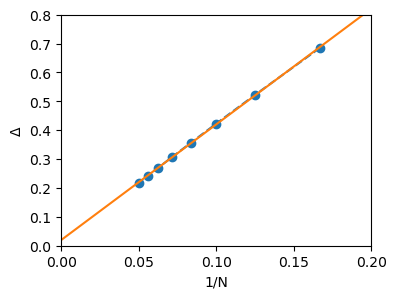

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc7b1cb7f40>

In [15]:
figure(figsize=(4,3))
plot(x, y, "o--")
xlim(0, 0.2)
ylim(0, 0.8)
xlabel("1/N")
ylabel(L"\Delta");

x1 = 0:0.001:0.2
plot(x1, fun(x1, coef(res)))

We see that the gap scales as $1/N$ indicating the systems is gapless